In [2]:
! pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=3e523eadffe5bd14bf0341568ccd9cffd46e0f4b98867f403551a8fdea5c72b7
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Convert Excel format to CSV format.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv')

In [6]:
from pyspark.sql import SparkSession

In [7]:

spark = SparkSession.builder.master("local[1]") \
                    .appName('ReadDataExample') \
                    .getOrCreate()
print(spark.sparkContext)
print("Spark App Name : "+ spark.sparkContext.appName)

<SparkContext master=local[1] appName=ReadDataExample>
Spark App Name : ReadDataExample


Read csv.

In [8]:
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [9]:
df.show(5)

+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017|27750|                0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017|29023|                0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017|45630|               17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017|26789|                0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SK

In [10]:
display( df )

DataFrame[Product: string, date: string, Sales: int, Price Discount (%): string, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int]

Check if there are missing values.

In [11]:
from pyspark.sql.functions import col, isnan, when, count

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns if df.schema[c].dataType != 'date'])
missing_counts.show()

+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      0|   0|    0|                 0|             0|              0|              0|              0|         0|    0|     0|        0|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+



**Observation**  
No missng values existing

In [12]:
df.count(), len(df.columns)

(1218, 12)

**Observation**  
1218 observations and 12 columns.

In [13]:
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- date: string (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: integer (nullable = true)
 |-- Catalogue Promo: integer (nullable = true)
 |-- Store End Promo: integer (nullable = true)
 |-- Google_Mobility: double (nullable = true)
 |-- Covid_Flag: integer (nullable = true)
 |-- V_DAY: integer (nullable = true)
 |-- EASTER: integer (nullable = true)
 |-- CHRISTMAS: integer (nullable = true)



**Observation**   
PySpark does not support "categorical" data type. So, we don't convert the data type for "In-Store Promo", "Catalogue Promo", "Store End Promo", "Covid_Flag", "V_DAY", "EASTER", and "CHRISTMAS".  In general, PySpark uses "string" and "integer" for "categorical" values.  

In [14]:
df.select("Sales", "Google_Mobility")

DataFrame[Sales: int, Google_Mobility: double]

Validate the name of columns. Put _ between word in stead of space.

In [15]:
df = (
    df
    .withColumnRenamed("Price Discount (%)", "Price_Discount")
    .withColumnRenamed("In-Store Promo", "In-Store_Promo")
    .withColumnRenamed("Catalogue Promo", "Catalogue_Promo")
    .withColumnRenamed("Store End Promo", "Store_End_Promo")
)

In [16]:
df.show(5)

+-------+---------+-----+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+-----+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017|27750|            0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017|29023|            0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017|45630|           17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017|26789|            0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SKU1| 3/5/2017|41999|         

In [17]:
duplicates = df.groupBy("Product").count().filter(col("count") > 1)
duplicates.show()

+-------+-----+
|Product|count|
+-------+-----+
|   SKU3|  204|
|   SKU4|  204|
|   SKU1|  204|
|   SKU5|  204|
|   SKU6|  198|
|   SKU2|  204|
+-------+-----+



**Observation**  
6products with only SKU6 has 198 counts while others are 204 counts.   

In [18]:
description = df.describe()
description.show()

+-------+-------+---------+------------------+--------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|summary|Product|     date|             Sales|Price_Discount|    In-Store_Promo|    Catalogue_Promo|    Store_End_Promo|    Google_Mobility|         Covid_Flag|               V_DAY|              EASTER|           CHRISTMAS|
+-------+-------+---------+------------------+--------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|  count|   1218|     1218|              1218|          1218|              1218|               1218|               1218|               1218|               1218|                1218|                1218|                1218|
|   mean|   NULL|     NULL|30294.678981937603|          NULL|0.4720853858784893|0.21264367816091953|0.34

In [19]:
df = df.withColumn("Sales", col("Sales").cast(IntegerType()))

In [20]:
df.describe().toPandas()

,summary,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,count,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
1,mean,None,None,30294.678981937603,None,0.4720853858784893,0.21264367816091953,0.34893267651888343,-2.3774055829228224,0.22660098522167488,0.019704433497536946,0.019704433497536946,0.018883415435139574
2,stddev,None,None,35032.5272965258,None,0.4994252268419534,0.40934571855807333,0.47682841234861867,5.806290981009834,0.4188042296935616,0.13903970926580328,0.13903970926580325,0.13616921612117958
3,min,SKU1,1/12/2020,0,0%,0,0,0,-28.49,0,0,0,0
4,max,SKU6,9/9/2018,288322,9%,1,1,1,3.9,1,1,1,1


Impute SKU6 with 0 since other poducts has 0 during the specific term between 11/22/2020 and 12/27/2020.  
SKU1, SKU3, and SKU6 has high sales amounts so ipute the median of each date of SKU1 and SKU3 each variable.  

In [21]:
from pyspark.sql import Row

data_to_append = [
    Row(Product="SKU6", date="2020-11-22", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-11-29", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-06", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-13", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-20", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-27", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0)
]

In [22]:
new_data_df = spark.createDataFrame(data_to_append)

df = df.union(new_data_df)

df.show()

+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017| 27750|            0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017| 29023|            0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017| 45630|           17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017| 26789|            0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SKU1| 3/5/2017| 41999| 

In [23]:
df.toPandas()

,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1219,SKU6,2020-11-29,0,0,0,0,0,0.0,1,0,0,0
1220,SKU6,2020-12-06,0,0,0,0,0,0.0,1,0,0,0
1221,SKU6,2020-12-13,0,0,0,0,0,0.0,1,0,0,0
1222,SKU6,2020-12-20,0,0,0,0,0,0.0,1,0,0,0


In [24]:
#df.write.csv("check.csv", header=True, mode="overwrite")

PySpark is not good at Visualization. So, we convert it to pandas format to plot graphs.

In [25]:
pandas_df = df.toPandas()

In [26]:
pandas_df.describe(include= ['object']).T

,count,unique,top,freq
Product,1224,6,SKU1,204
date,1224,210,2/5/2017,6
Price_Discount,1224,71,0%,231


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

In [28]:
from pyspark.sql.functions import when, lit, col

df = df.withColumn("Holiday_Flag", when((col("V_DAY") == 1) | (col("EASTER") == 1) | (col("CHRISTMAS") == 1), lit(1)).otherwise(lit(0)))
df= df.drop("V_DAY", "EASTER", "CHRISTMAS")
df.show()

+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|Product|     date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|   SKU1| 2/5/2017| 27750|            0%|             0|              0|              0|            0.0|         0|           0|
|   SKU1|2/12/2017| 29023|            0%|             1|              0|              1|            0.0|         0|           1|
|   SKU1|2/19/2017| 45630|           17%|             0|              0|              0|            0.0|         0|           0|
|   SKU1|2/26/2017| 26789|            0%|             1|              0|              1|            0.0|         0|           0|
|   SKU1| 3/5/2017| 41999|           17%|             0|              0|              0|         

In [29]:
#df.write.csv("forecasting_case_study2.csv", header=True, mode="overwrite")

In [30]:
df.head()

Row(Product='SKU1', date='2/5/2017', Sales=27750, Price_Discount='0%', In-Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility=0.0, Covid_Flag=0, Holiday_Flag=0)

<Axes: xlabel='date', ylabel='Sales'>

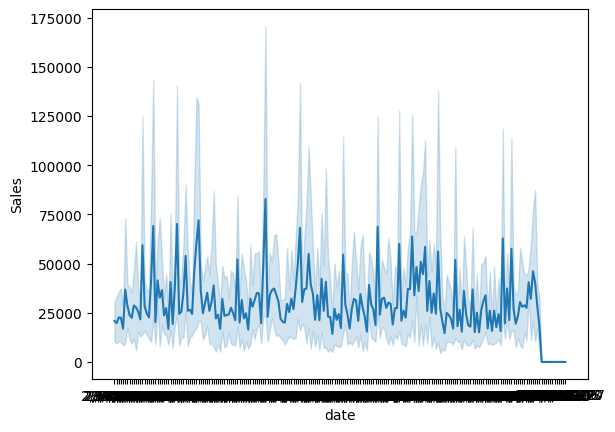

In [31]:
sns.lineplot(x = 'date', y = 'Sales', data=pandas_df)

In [32]:
df.write.option("header", True) \
        .partitionBy("Product") \
        .mode("overwrite") \
        .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [33]:
df1=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU1")

In [34]:
df2=spark.read.option("header",True) \
           .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU2")

In [35]:
df3=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU3")

In [36]:
df4=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU4")

In [37]:
df5=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU5")

In [38]:
df6=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU6")

In [39]:
#df_all = spark.read.parquet("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [40]:
products = [df1,df2,df3,df4,df5,df6]

In [41]:
for i in range(len(products)):
  print(products[i].head())
  products[i].printSchema()
  products[i].show()
  products[i]= products[i].toPandas()

Row(date='2/5/2017', Sales='27750', Price_Discount='0%', In-Store_Promo='0', Catalogue_Promo='0', Store_End_Promo='0', Google_Mobility='0.0', Covid_Flag='0', Holiday_Flag='0')
root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price_Discount: string (nullable = true)
 |-- In-Store_Promo: string (nullable = true)
 |-- Catalogue_Promo: string (nullable = true)
 |-- Store_End_Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- Holiday_Flag: string (nullable = true)

+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|     date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
| 2/5/2017| 27750|            0%|             0|              0

In [42]:
def histplot_boxplot(feature, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined

    feature: 1-d feature array

    figsize: size of fig (default (9, 8))

    bins: number of bins (default None / auto)

    """
    f2, (ax_box2, ax_his2) = plt.subplots(nrows=2,  # Number of rows of the subplot grid = 2
                                           sharex=True,  # X-axis will be shared among all subplots
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize
                                           )  # Creating the 2 subplots

    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet')  # Boxplot will be created and a symbol will indicate the mean value of the column

    if bins:
        sns.histplot(x=feature, kde=True, ax=ax_his2, bins=bins, palette="winter")  # For histogram
    else:
        sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram

    ax_his2.axvline(np.mean(feature), color='green', linestyle='--')  # Add mean to the histogram

    ax_his2.axvline(np.median(feature), color='black', linestyle='-')  # Add median to the histogram


In [43]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan

In [44]:
df1.dtypes

[('date', 'string'),
 ('Sales', 'string'),
 ('Price_Discount', 'string'),
 ('In-Store_Promo', 'string'),
 ('Catalogue_Promo', 'string'),
 ('Store_End_Promo', 'string'),
 ('Google_Mobility', 'string'),
 ('Covid_Flag', 'string'),
 ('Holiday_Flag', 'string')]

In [45]:
#for i in products:
 # print(i.head())
  #df1['Price_Discount']=df1['Price_Discount'].str.rstrip('%').astype(float)/100
  #df1 = df1.withColumn("Price_Discount", col("Price_Discount").cast("int"))
  #print(df1.head())

In [46]:

'''df1['Price_Discount'] = df1['Price_Discount'].apply(convert_to_int,axis=1)'''

"df1['Price_Discount'] = df1['Price_Discount'].apply(convert_to_int,axis=1)"

In [47]:

  #i['Price_Discount']= i['Price_Discount'].str[:-1]

  #i['Price_Discount']= i['Price_Discount'].astype(int)

In [48]:
for i in products:
  print(i.head())

        date  Sales Price_Discount In-Store_Promo Catalogue_Promo  \
0   2/5/2017  27750             0%              0               0   
1  2/12/2017  29023             0%              1               0   
2  2/19/2017  45630            17%              0               0   
3  2/26/2017  26789             0%              1               0   
4   3/5/2017  41999            17%              0               0   

  Store_End_Promo Google_Mobility Covid_Flag Holiday_Flag  
0               0             0.0          0            0  
1               1             0.0          0            1  
2               0             0.0          0            0  
3               1             0.0          0            0  
4               0             0.0          0            0  
        date Sales Price_Discount In-Store_Promo Catalogue_Promo  \
0   2/5/2017  7180            25%              1               0   
1  2/12/2017  7080            25%              0               0   
2  2/19/2017  2753   

In [49]:
df1.head()

Row(date='2/5/2017', Sales='27750', Price_Discount='0%', In-Store_Promo='0', Catalogue_Promo='0', Store_End_Promo='0', Google_Mobility='0.0', Covid_Flag='0', Holiday_Flag='0')

In [50]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 37.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.16.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.


In [51]:
cols=['Sales','In-Store_Promo','Catalogue_Promo','Store_End_Promo','Google_Mobility','Covid_Flag','Holiday_Flag']
for i in range(len(products)):
  products[i] = ps.DataFrame(products[i])
  products[i]['Price_Discount']=products[i]['Price_Discount'].apply(convert_to_int)
  products[i]['Sales']=products[i]['Sales'].apply(pd.to_numeric)
  products[i]['In-Store_Promo']=products[i]['In-Store_Promo'].apply(pd.to_numeric)
  products[i]['Catalogue_Promo']=products[i]['Catalogue_Promo'].apply(pd.to_numeric)
  products[i]['Store_End_Promo']=products[i]['Store_End_Promo'].apply(pd.to_numeric)
  products[i]['Google_Mobility']=products[i]['Google_Mobility'].apply(pd.to_numeric)
  products[i]['Covid_Flag']=products[i]['Covid_Flag'].apply(pd.to_numeric)
  products[i]['Holiday_Flag']=products[i]['Holiday_Flag'].apply(pd.to_numeric)
  #i['date']=i['date'].apply(pd.to_datetime,axis=1)
  print(products[i].dtypes)

date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag 

In [52]:
for i in products:
  print(i.dtypes)

date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount     float64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag 

Product : 1


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


Product : 2


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


Product : 3


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Product : 4


<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Product : 5


<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Product : 6


<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


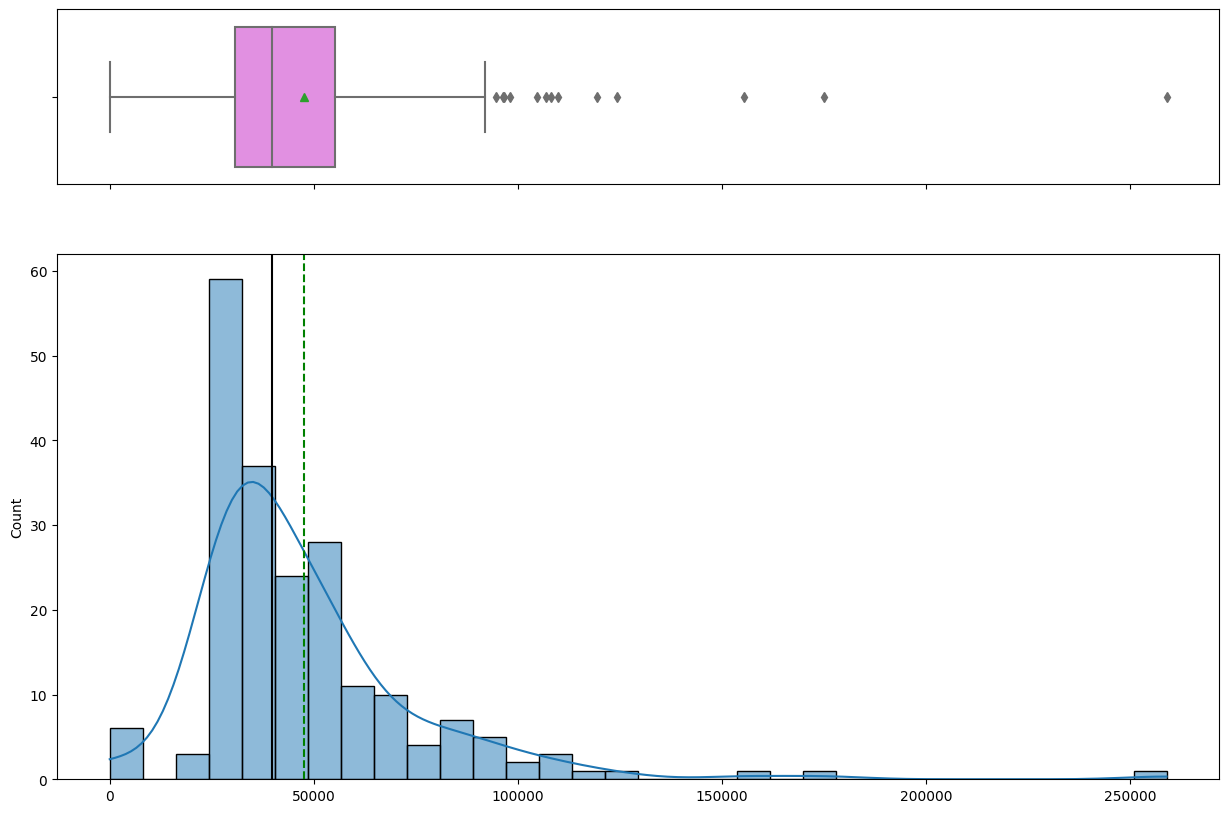

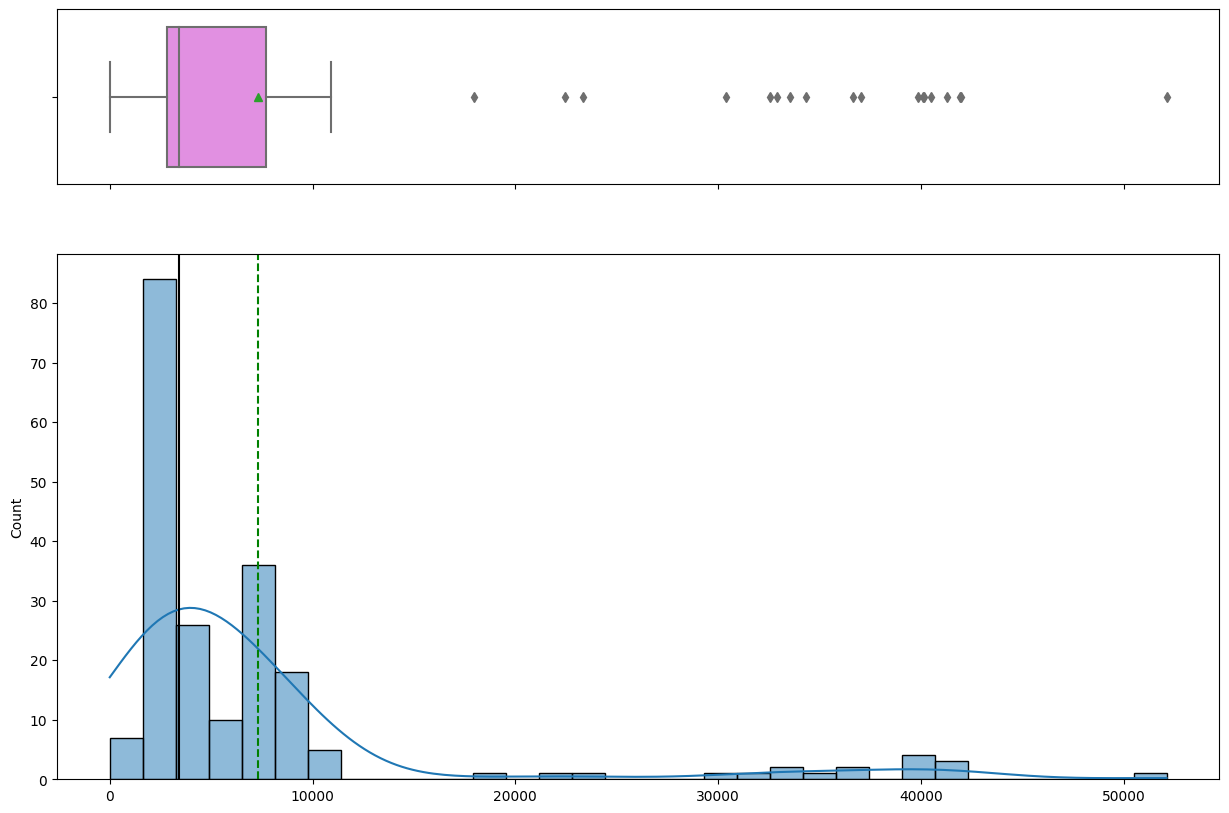

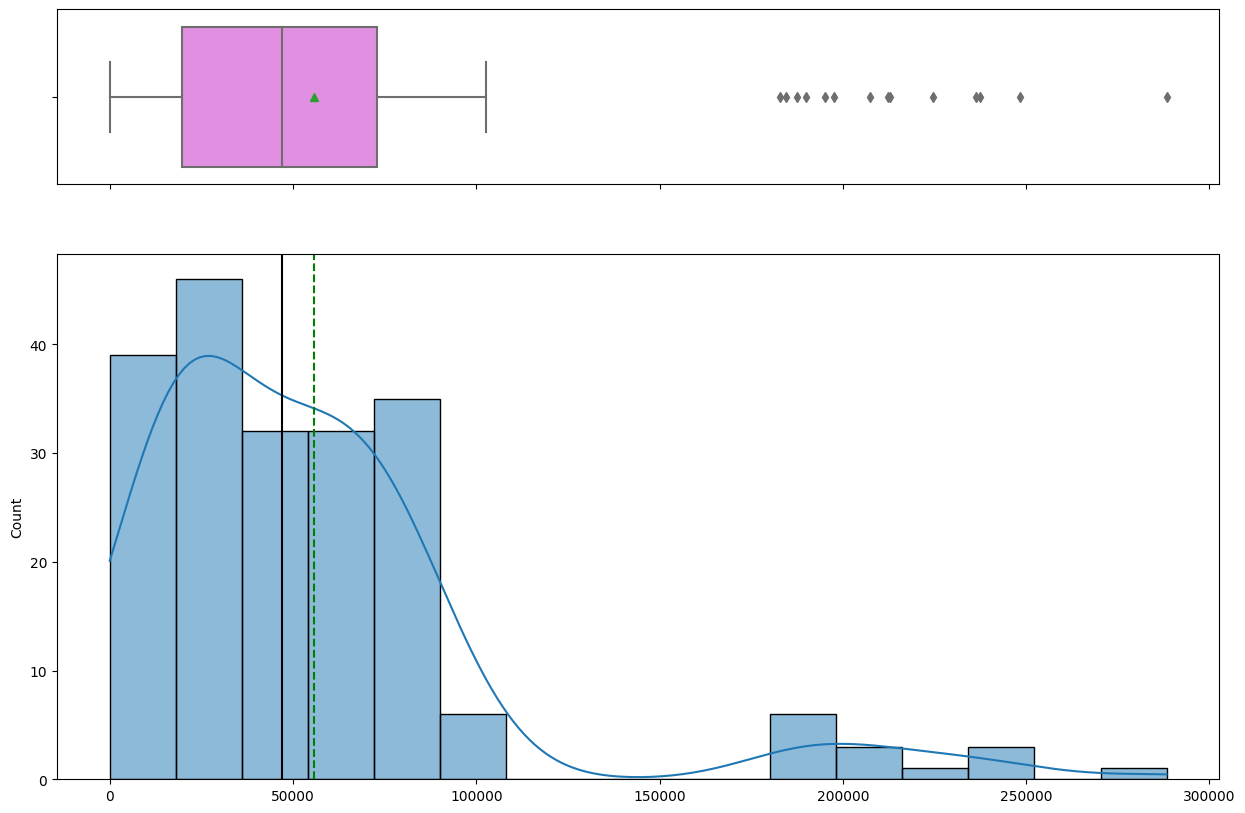

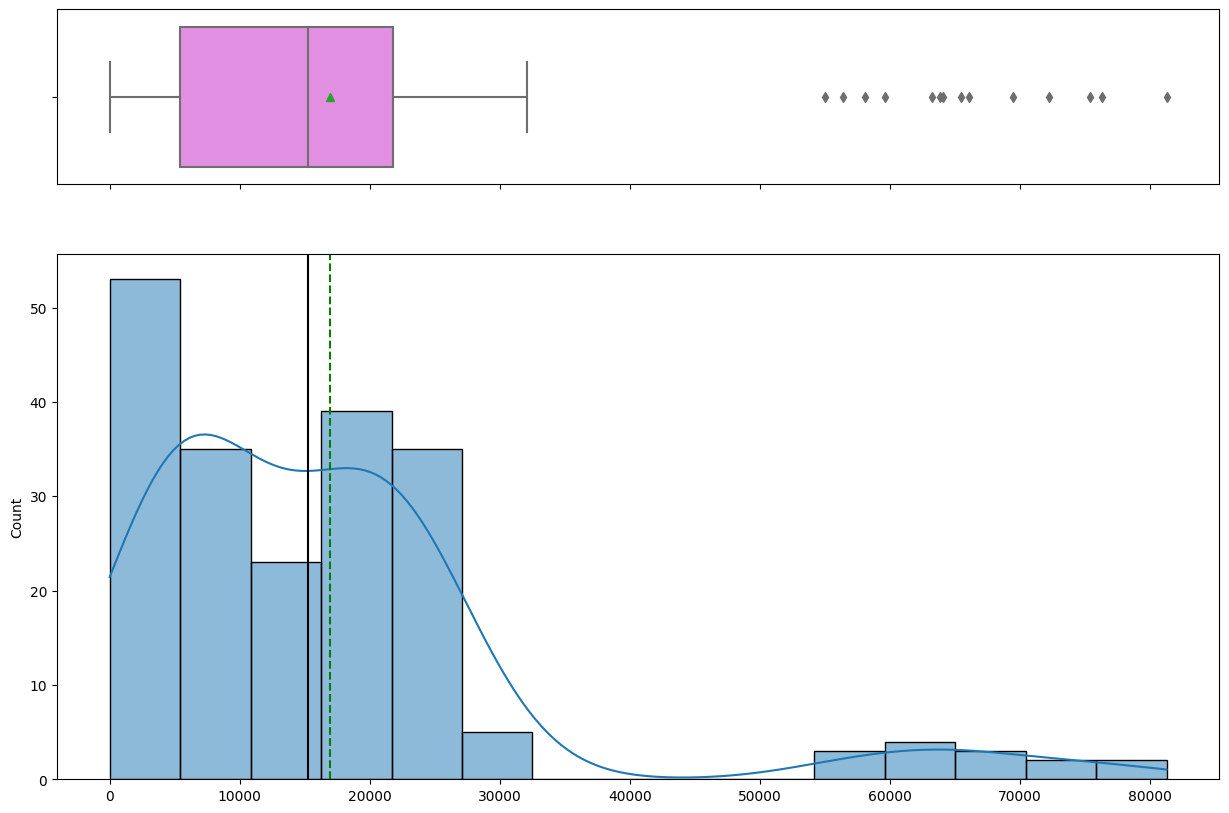

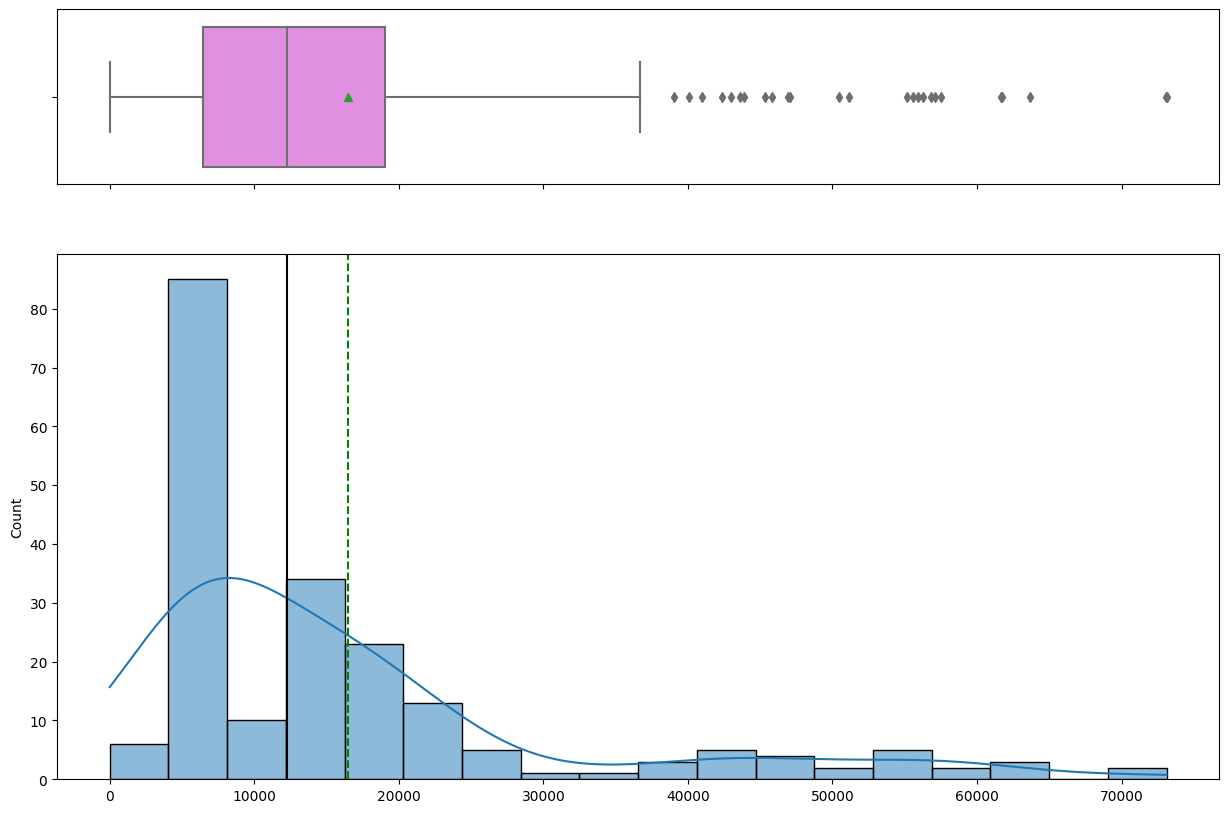

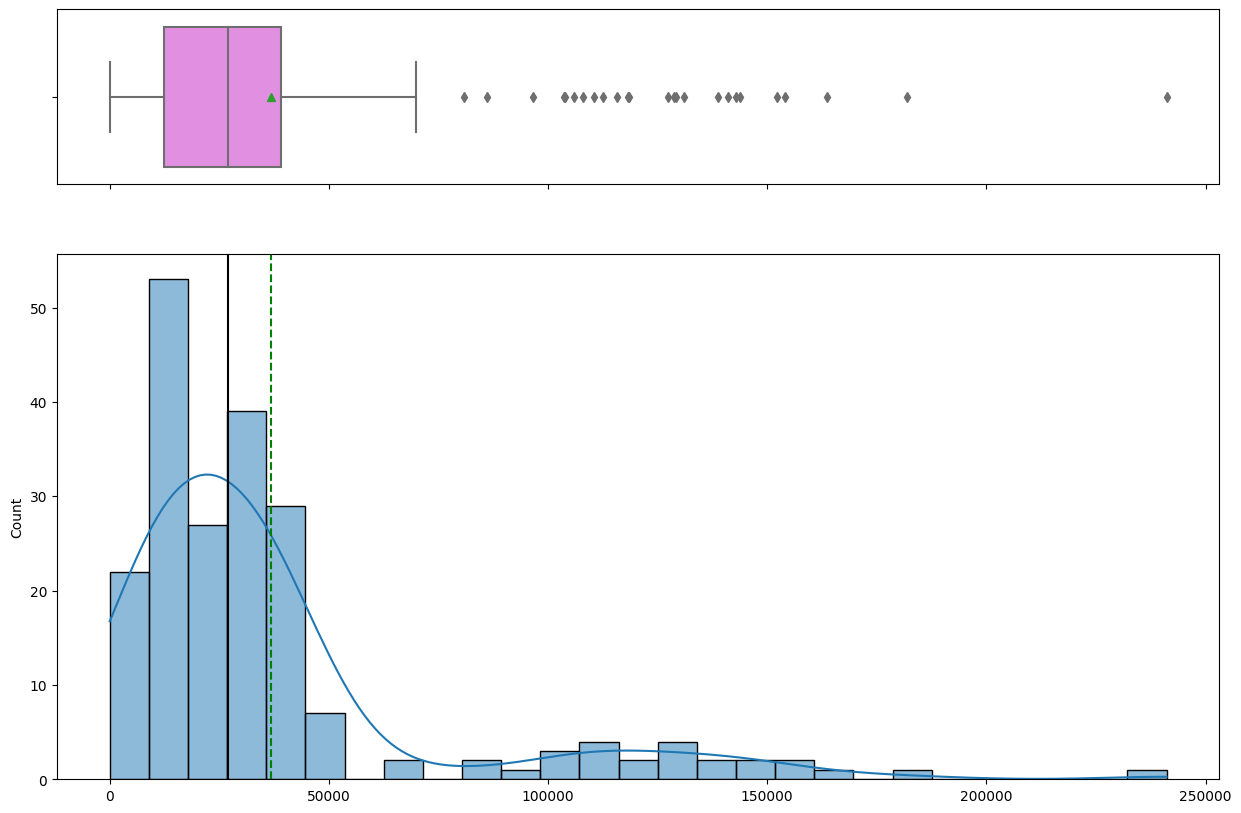

In [53]:
for i in range(len(products)):
  print('Product :',i+1)
  histplot_boxplot(products[i]['Sales'].to_numpy())
  products[i].describe

In [54]:
from pyspark.sql.functions import col, exp

In [55]:
for i in range(len(products)):
    Q1 = np.percentile(products[i]['Sales'].to_numpy(), 25, method='midpoint')

    # Check if 'Sales' column is not empty before calculating Q3
    if not products[i]['Sales'].empty:
        Q3 = np.percentile(products[i]['Sales'].to_numpy(), 75, method='midpoint')
        IQR = Q3 - Q1
        print(IQR)
    else:
        print("Warning: 'Sales' column is empty for product", i)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


24606.0
4891.0
53491.5
16423.5
12673.5
26869.0


In [56]:
# #q_hi  = df1['Sales'].quantile(0.99)
# for i in range(len(products)):

#   '''quantiles = products[i].approxQuantile('Sales', [0.25, 0.75], 0.01)
#   q1, q3 = quantiles[0], quantiles[1]
#   iqr = q3 - q1

#   # Define the upper and lower bounds for outliers
#   lower_bound = q1 - 1.5 * iqr
#   upper_bound = q3 + 1.5 * iqr'''
#   print(products[i]['Sales'])

#   # Q1 = np.percentile(products[i]['Sales'].to_numpy(), 25, method='midpoint')
#   # Q3 = np.percentile(df1['Sales'], 75, method='midpoint')
#   # IQR = Q3 - Q1
#   # print(IQR)
#   # upper= 1.0*IQR #make the range of outliers narrower.
#   # df1 = df1[(df1['Sales'] < upper)]

In [57]:
df1_exclude= df1.toPandas().iloc[:, 1:]

In [58]:
df2.describe()

DataFrame[summary: string, date: string, Sales: string, Price_Discount: string, In-Store_Promo: string, Catalogue_Promo: string, Store_End_Promo: string, Google_Mobility: string, Covid_Flag: string, Holiday_Flag: string]

In [62]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     df1test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df1test[0])
     print("2. P-Value : ", df1test[1])
     print("3. Num Of Lags : ", df1test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df1test[3])
     print("5. Critical Values :")
     for key, val in df1test[4].items():
         print("\t",key, ": ", val)



In [63]:
for i in range(len(products)):
  print('Product :',i+1)
  adf_test(products[i]['Sales'].to_numpy())

Product : 1
1. ADF :  -8.709706503878769
2. P-Value :  3.618956850660834e-14
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 203
5. Critical Values :
	 1% :  -3.462980134086401
	 5% :  -2.875885461947131
	 10% :  -2.5744164898444515
Product : 2
1. ADF :  -15.101046528996793
2. P-Value :  7.939761191320426e-28
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 203
5. Critical Values :
	 1% :  -3.462980134086401
	 5% :  -2.875885461947131
	 10% :  -2.5744164898444515
Product : 3
1. ADF :  -5.752369671199724
2. P-Value :  5.925779849523968e-07
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 200
5. Critical Values :
	 1% :  -3.463476079125
	 5% :  -2.876102355
	 10% :  -2.574532225
Product : 4
1. ADF :  -5.5897596756076915
2. P-Value :  1.3374036538055731e-06
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 200
5. Critical Values :
	 1% :  -3.463476079125
	 5% :  -2.876102355
	 

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the 

10% :  -2.574532225
Product : 5
1. ADF :  -4.4077527942881805
2. P-Value :  0.00028759403371084495
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression: 199
5. Critical Values :
	 1% :  -3.4636447617687436
	 5% :  -2.8761761179270766
	 10% :  -2.57457158581854
Product : 6
1. ADF :  -5.372403759091321
2. P-Value :  3.869847956610345e-06
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 200
5. Critical Values :
	 1% :  -3.463476079125
	 5% :  -2.876102355
	 10% :  -2.574532225


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


**Observation**  
P-value became 0.05 that provides the data is stationary.  

**Observation**  
Covid Flag started from February 09, 2020.  

In [64]:
! pip install plotly

In [65]:
import plotly.express as px

pandas_df = df.toPandas()

fig = px.line(pandas_df, x='date', y='Google_Mobility', title='Google_Mobility')

min_desired_value = -30
max_desired_value = 10
fig.update_yaxes(range=[min_desired_value, max_desired_value])

fig.show()

**Observation**  
-Google Mobility is realted Covid19. This is because the line is flat until February 2, 2020 above the plot. The flat line means there are no activities and no exisiting record.   
-After February 9, 2020, it started fluctuating and keep changing. According to the variable Covid Flag, it started recorded as 1 after February 9, 2020. The timing between Google Mobility and Covid Flag is exactly coinside.  
-Google Mobility data tracks travel patterns in detail, such as how often people go to public places and how much time they spend commuting or shopping. This will allow us to assess the risk of spread of infection and predict the spread of infection in a particular region or city.  

**To analyze the data pre-Covid and post-Covid, we divide the data to 2.**

In [66]:
before_date = df.filter(col("date") < "2020-02-09")

after_date = df.filter(col("date") >= "2020-02-09")

before_date.show()
after_date.show()

+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|Product|      date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|   SKU1|  2/5/2017| 27750|            0%|             0|              0|              0|            0.0|         0|           0|
|   SKU1| 2/12/2017| 29023|            0%|             1|              0|              1|            0.0|         0|           1|
|   SKU1| 2/19/2017| 45630|           17%|             0|              0|              0|            0.0|         0|           0|
|   SKU1| 2/26/2017| 26789|            0%|             1|              0|              1|            0.0|         0|           0|
|   SKU1| 10/1/2017| 96610|           44%|             0|              0|              0| 

In [67]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

before_date = before_date.withColumn('Sales', col('Sales').cast(FloatType()))

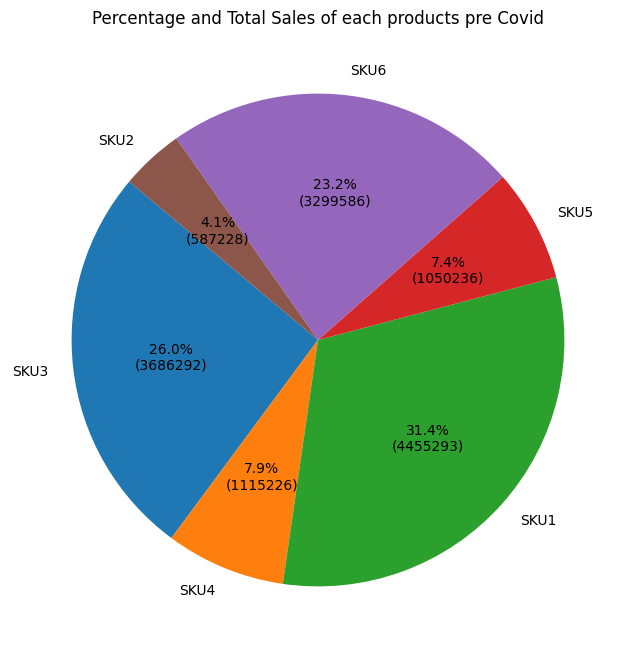

In [68]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

In [69]:
from pyspark.sql.functions import col

null_columns = [col(c).alias(c) for c in after_date.columns]

after_date.select(null_columns).filter(after_date['Sales'].isNull()).show()

+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+
|Product|date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+
+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+



In [70]:
after_date1 = after_date.toPandas()
after_date1.isnull().any()

Product            False
date               False
Sales              False
Price_Discount     False
In-Store_Promo     False
Catalogue_Promo    False
Store_End_Promo    False
Google_Mobility    False
Covid_Flag         False
Holiday_Flag       False
dtype: bool

In [71]:
print(after_date1[after_date1['Sales'].isnull()])

Empty DataFrame
Columns: [Product, date, Sales, Price_Discount, In-Store_Promo, Catalogue_Promo, Store_End_Promo, Google_Mobility, Covid_Flag, Holiday_Flag]
Index: []


In [72]:
after_date = after_date[after_date['Sales'] != 0]

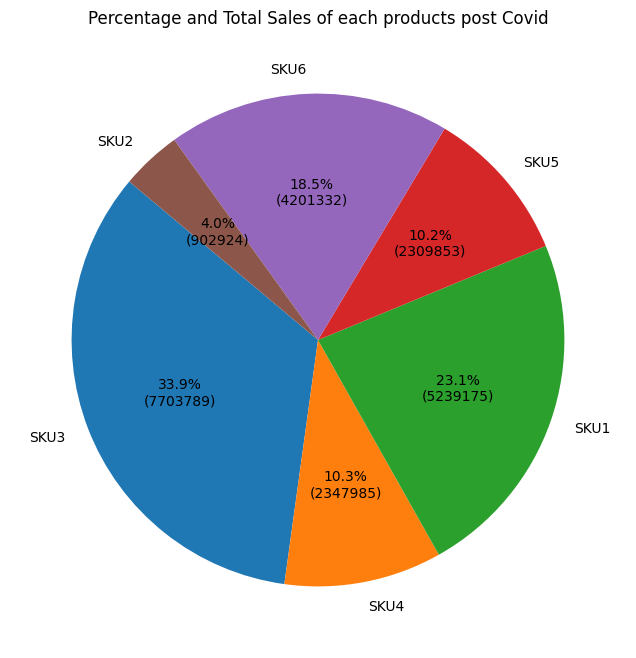

In [73]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

after_date = after_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales2 = after_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales2.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products post Covid')

plt.show()


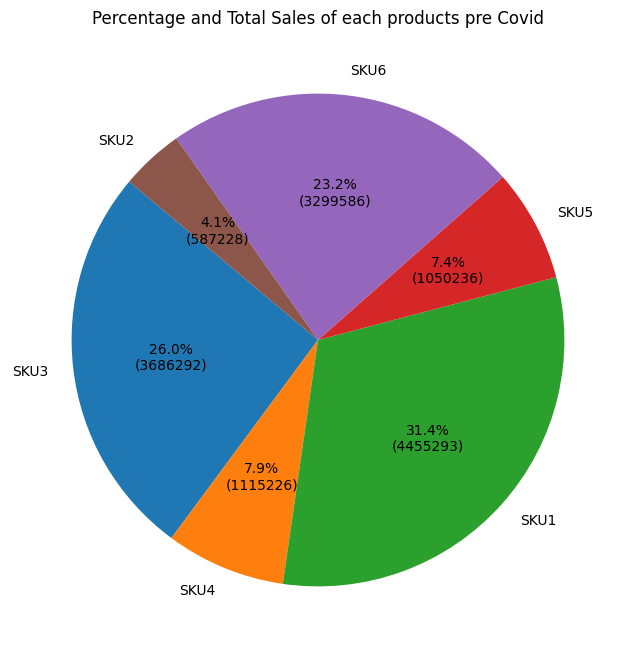

In [74]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

**Observation**  
In terms of the percantages of the products to sales, there are no very big difference between pre covid and post covid.  
In general both before Covid and after Covid, SKU3 is the most popular products. SKU1 is the secondest popular. And SKU6 is the 3rd.   
SKU4 and SKU5 are kinds of same sales amounts. And SKU2 is the least popular products.  

In [75]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

spark = SparkSession.builder.appName("SalesComparison").getOrCreate()

before_covid_sales = before_date.groupBy("Product").agg(sum("Sales").alias("Sales_before_covid"))
after_covid_sales = after_date.groupBy("Product").agg(sum("Sales").alias("Sales_after_covid"))

sales_comparison_table = before_covid_sales.join(after_covid_sales, "Product", "outer")

sales_comparison_table = sales_comparison_table.withColumn("Sales_change", ((col("Sales_after_covid") - col("Sales_before_covid")) / col("Sales_before_covid")) * 100)

sales_comparison_table.show()

+-------+------------------+-----------------+------------------+
|Product|Sales_before_covid|Sales_after_covid|      Sales_change|
+-------+------------------+-----------------+------------------+
|   SKU1|         4455293.0|          5239175|17.594398393102317|
|   SKU2|          587228.0|           902924| 53.76037927346788|
|   SKU3|         3686292.0|          7703789|108.98477385947723|
|   SKU4|         1115226.0|          2347985|110.53894008927338|
|   SKU5|         1050236.0|          2309853|119.93656663835557|
|   SKU6|         3299586.0|          4201332| 27.32906491905348|
+-------+------------------+-----------------+------------------+



**Observation**  
Sales of all of products significantly reduced between 70% and 80% minus after Covid compared to before Covid.  

In [76]:
from pyspark.sql.types import IntegerType

df_hist = df.withColumn("Sales", col("Sales").cast(IntegerType()))

hist_data = df_hist.select("Sales").rdd.flatMap(lambda x: x).histogram(10)

print(hist_data)

([0.0, 28832.2, 57664.4, 86496.6, 115328.8, 144161.0, 172993.2, 201825.4, 230657.6, 259489.80000000002, 288322], [768, 287, 109, 25, 13, 4, 8, 4, 5, 1])


In [77]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

df = df.withColumn("Sales", col("Sales").cast(DoubleType()))

df = df.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df.corr("Sales", "Google_Mobility")

print(correlation)

0.05691633839446528


In [78]:
df_corr1 = before_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df_corr1 = df_corr1.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df_corr1.corr("Sales", "Google_Mobility")

print(correlation)

0.090287941511131


In [79]:
df_corr2 = after_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df_corr2 = df_corr2.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df_corr2.corr("Sales", "Google_Mobility")

print(correlation)

0.06326938251423628


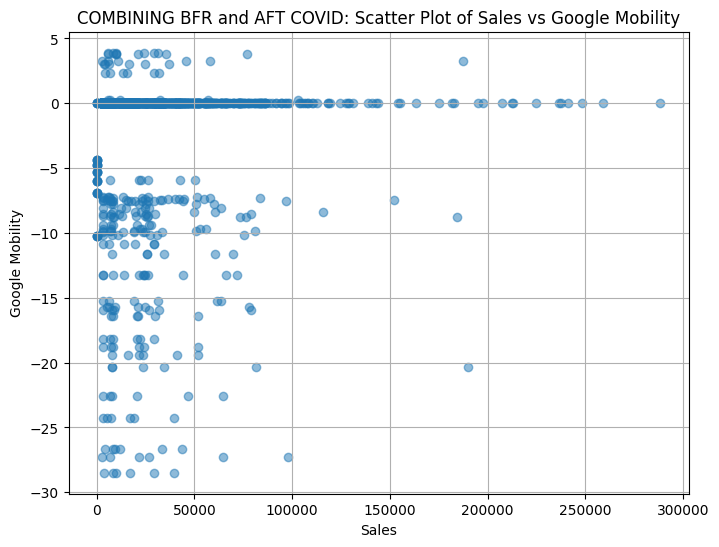

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.toPandas()

sales_column = pandas_df["Sales"]
google_mobility_column = pandas_df["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("COMBINING BFR and AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

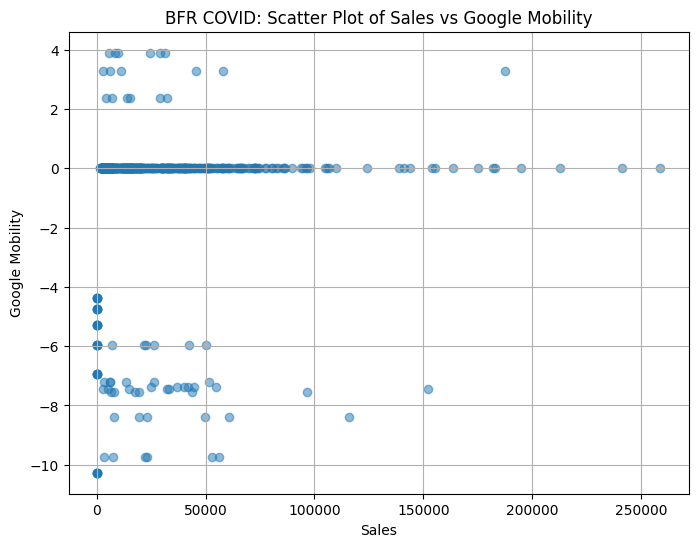

In [81]:
pandas_df1 = before_date.toPandas()

sales_column = pandas_df1["Sales"]
google_mobility_column = pandas_df1["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("BFR COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

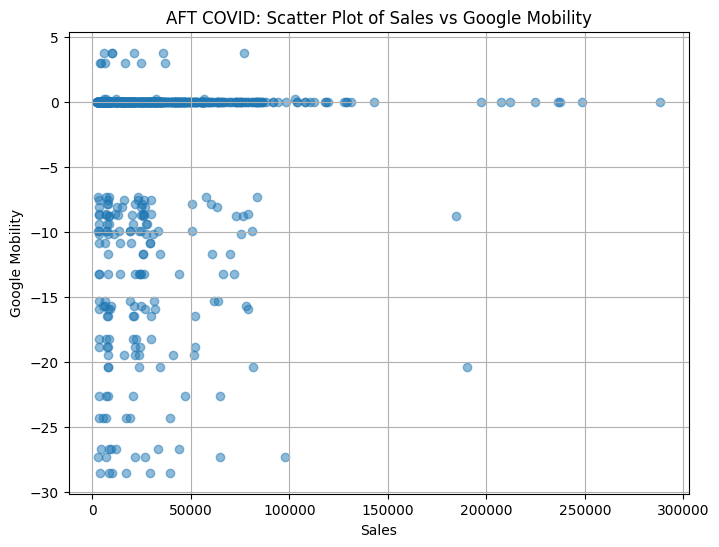

In [82]:
pandas_df2 = after_date.toPandas()

pandas_df2 = pandas_df2.sort_values(by="Google_Mobility")

sales_column = pandas_df2["Sales"]
google_mobility_column = pandas_df2["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

In [83]:
cross_tab = df.crosstab("Product", "Covid_flag")
print(cross_tab)

DataFrame[Product_Covid_flag: string, 0: bigint, 1: bigint]


**Recommendation**  
Since the sales of the bebarage company is too differnt between before Covid and after Covid, we recommend to use the data after Covid to build model and demostrate accuracy for Q3-Q4 of 2020.
If we include the data with before Covid, that is totaly different circumstance that will provides inaccurate prediction.
However, in term of exploring more opportunities to be able to use multiplie methods, we also recommend to use entire of dataset. This is because only EDA can't fugure it out the accurate insights.  

#Multivariate Time Series Modeling using VAR (Vector Autoregression)  

-This data is not stational. It is better to be stational but it was not able to adjust it with any method. Applyong VAR, we need to have stational data. That means we can't use it for this data.  

#Multivariate Time Series Modeling using XGBoost  

In [130]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [131]:
df2

DataFrame[date: string, Sales: string, Price_Discount: string, In-Store_Promo: string, Catalogue_Promo: string, Store_End_Promo: string, Google_Mobility: string, Covid_Flag: string, Holiday_Flag: string]

In [132]:
import matplotlib.pyplot as plt

In [140]:
df2_input = df2[['Sales', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

In [141]:
import pandas as pd

# Assuming df2_input is a PySpark DataFrame
pandas_df = df2_input.toPandas()  # Convert PySpark DataFrame to Pandas DataFrame
df2_input = pandas_df.to_numpy()  # Convert Pandas DataFrame to NumPy array


print(df2_input)

[['7180' '1' '0' ... '0.0' '0' '0']
 ['7080' '0' '0' ... '0.0' '0' '1']
 ['2753' '0' '0' ... '0.0' '0' '0']
 ...
 ['0' '0' '0' ... '-4.74' '1' '0']
 ['0' '0' '0' ... '-10.27' '1' '1']
 ['0' '0' '0' ... '-6.95' '1' '0']]


In [142]:
features2 = df2_input
target2 = df2_input[:, 0]

In [143]:
#X_pandas = X.toPandas()
#y_pandas = y.toPandas()

X_train, X_test, y_train, y_test = train_test_split(features2, target2, test_size=0.2, random_state=42)

In [144]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, random_state=42)

In [145]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [146]:
y_pred = model.predict(X_test)

In [147]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3058234.394631962


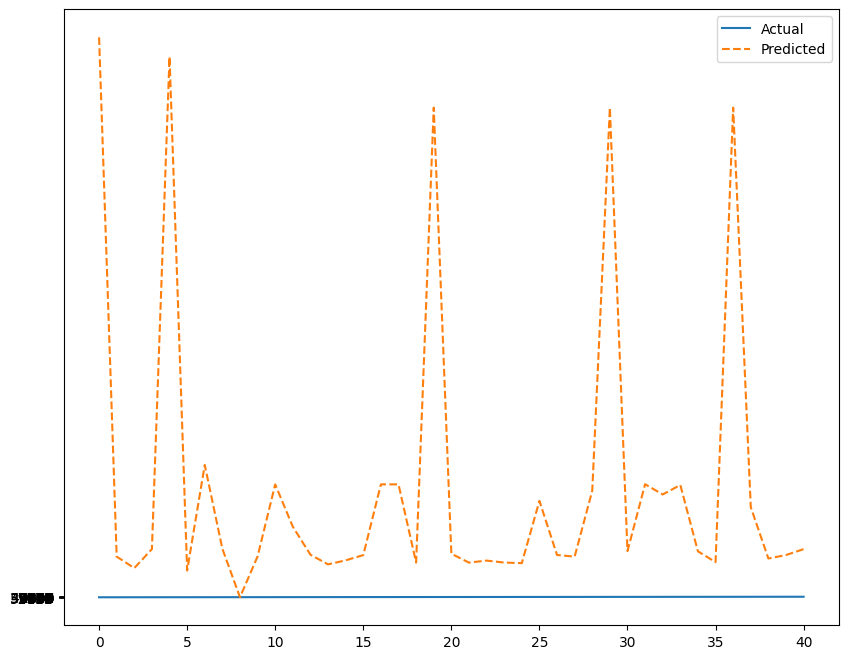

In [148]:
plt.plot(y_test, label='Actual', linestyle='-')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.show()

#Multivariate Time Series Modeling using SVM (Support Vector Machine)

In [149]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


In [158]:
import pmdarima as pm

# Assuming df2 is a PySpark DataFrame
sales_values = df2.select('Sales').limit(100).toPandas()['Sales'].values

model2 = pm.auto_arima(sales_values,
                      m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=2,
                      test='adf', error_action='ignore',
                      suppress_warnings=True)

In [163]:
train=df1.toPandas().iloc[:-30]
test=df1.toPandas().iloc[-30:]
train.head()


,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
0,2/5/2017,27750,0%,0,0,0,0.0,0,0
1,2/12/2017,29023,0%,1,0,1,0.0,0,1
2,2/19/2017,45630,17%,0,0,0,0.0,0,0
3,2/26/2017,26789,0%,1,0,1,0.0,0,0
4,3/5/2017,41999,17%,0,0,0,0.0,0,0


In [164]:

test.head()

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
174,6/7/2020,30877,1%,0,0,0,-10.13,1,0
175,6/14/2020,26244,1%,0,0,0,-8.68,1,0
176,6/21/2020,25445,1%,0,0,0,-8.57,1,0
177,6/28/2020,26410,1%,0,0,0,-7.5,1,0
178,7/5/2020,26925,1%,0,0,0,-8.04,1,0


In [165]:
train['Sales'] = pd.to_numeric(train['Sales'])
train.dtypes

date               object
Sales               int64
Price_Discount     object
In-Store_Promo     object
Catalogue_Promo    object
Store_End_Promo    object
Google_Mobility    object
Covid_Flag         object
Holiday_Flag       object
dtype: object

In [166]:
import statsmodels.api as sm


In [167]:
np.asarray(train)

array([['2/5/2017', 27750, '0%', ..., '0.0', '0', '0'],
       ['2/12/2017', 29023, '0%', ..., '0.0', '0', '1'],
       ['2/19/2017', 45630, '17%', ..., '0.0', '0', '0'],
       ...,
       ['5/17/2020', 31406, '1%', ..., '-15.27', '1', '0'],
       ['5/24/2020', 71971, '45%', ..., '-13.24', '1', '0'],
       ['5/31/2020', 29177, '3%', ..., '-10.86', '1', '0']], dtype=object)

In [168]:
test['Sales'] = pd.to_numeric(test['Sales'])

In [169]:
#from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Sales'],order=(2,0,0))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  174
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2022.736
Date:                Sun, 17 Dec 2023   AIC                           4053.472
Time:                        19:45:26   BIC                           4066.108
Sample:                             0   HQIC                          4058.598
                                - 174                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.054e+04   4690.218     10.776      0.000    4.13e+04    5.97e+04
ar.L1          0.3541      0.107      3.298      0.001       0.144       0.564
ar.L2          0.0713      0.068      1.049      0.294      -0.062       0.205
sigma2      7.368e+08      0.313   2.35e+09      0.000    7.37e+08    7.37e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1998.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                             2.97
Prob(H) (two-sided):                  0.04   Kurtosis:                        18.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+24. Standard errors may be unstable.
"""

In [171]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Sales'].mean()
rmse=sqrt(mean_squared_error(pred,test['Sales']))
print(rmse)


28484.192932092865
